# Analysis of Machine Failure

### Loading the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller,acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'
sns.set_style("whitegrid")


from pandas.tools.plotting import scatter_matrix
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import neural_network
from sklearn.model_selection import cross_val_predict
from sklearn import ensemble
from sklearn.metrics import roc_curve, auc

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
df = pd.read_csv('./maintenance_data.csv')
df.head()
df.shape

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1


(1000, 7)

### Some Data Statistics

In [3]:
%%time
#PS just checking the time performance of algorithm
tc1=tc2=tc3=tc4=0
c1=c2=c3=c4=0
for i in df.values:
    if i[6]=="Provider1":
        tc1+=1
        if i[1]==1:
            c1+=1
    if i[6]=="Provider2":
        tc2+=1
        if i[1]==1:
            c2+=1
    if i[6]=="Provider3":
        tc3+=1
        if i[1]==1:
            c3+=1
    if i[6]=="Provider4":
        tc4+=1
        if i[1]==1:
            c4+=1
print "Provider   Broken"
print "Provider1  0\t"+str(tc1-c1)
print "\t   1\t"+str(c1)
print "Provider2  0\t"+str(tc2-c2)
print "\t   1\t"+str(c2)
print "Provider3  0\t"+str(tc3-c3)
print "\t   1\t"+str(c3)
print "Provider4  0\t"+str(tc4-c4)
print "\t   1\t"+str(c4)

Provider   Broken
Provider1  0	138
	   1	116
Provider2  0	175
	   1	91
Provider3  0	128
	   1	114
Provider4  0	162
	   1	76
CPU times: user 0 ns, sys: 7.38 ms, total: 7.38 ms
Wall time: 3.45 ms


In [4]:
%%time
#PS just checking the time performance of algorithm
x=df.groupby('provider').broken.value_counts()
print x

provider   broken
Provider1  0         138
           1         116
Provider2  0         175
           1          91
Provider3  0         128
           1         114
Provider4  0         162
           1          76
Name: broken, dtype: int64
CPU times: user 3.65 ms, sys: 0 ns, total: 3.65 ms
Wall time: 3.15 ms


In [5]:
df.groupby('team').broken.value_counts()

team   broken
TeamA  0         213
       1         123
TeamB  0         206
       1         150
TeamC  0         184
       1         124
Name: broken, dtype: int64

## Part 1 Visualising the Data

#### Plotting the output class versus lifetime for various providers

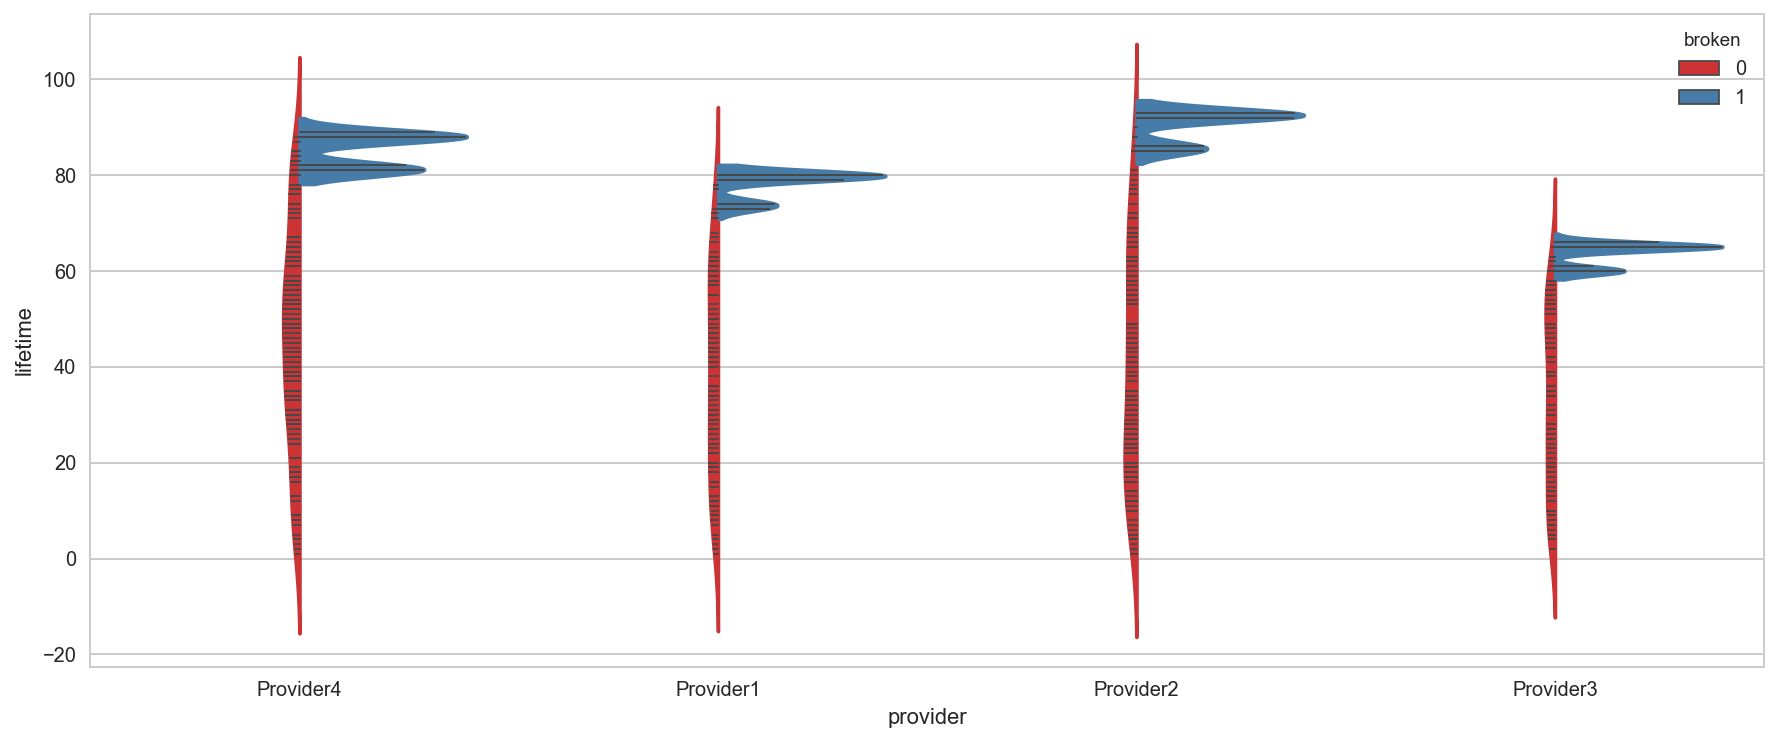

In [6]:
ax=sns.violinplot(x="provider", y="lifetime", hue="broken",split=True, inner="stick",data=df,palette="Set1")

#### Plotting the output class versus lifetime for various teams

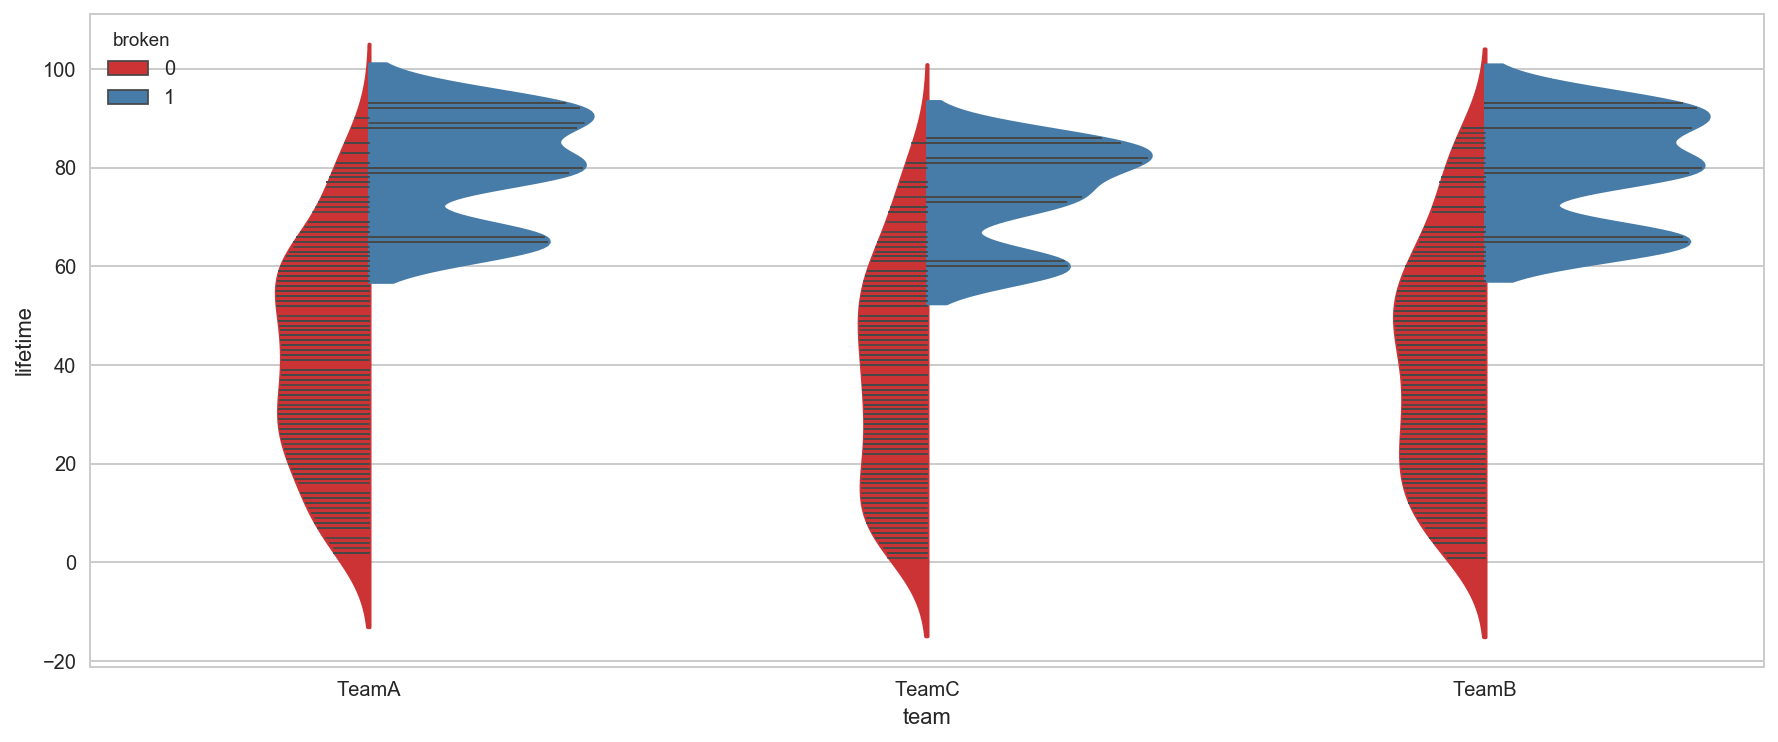

In [7]:
ax=sns.violinplot(x="team", y="lifetime", hue="broken", inner="stick",split=True,data=df,palette="Set1")

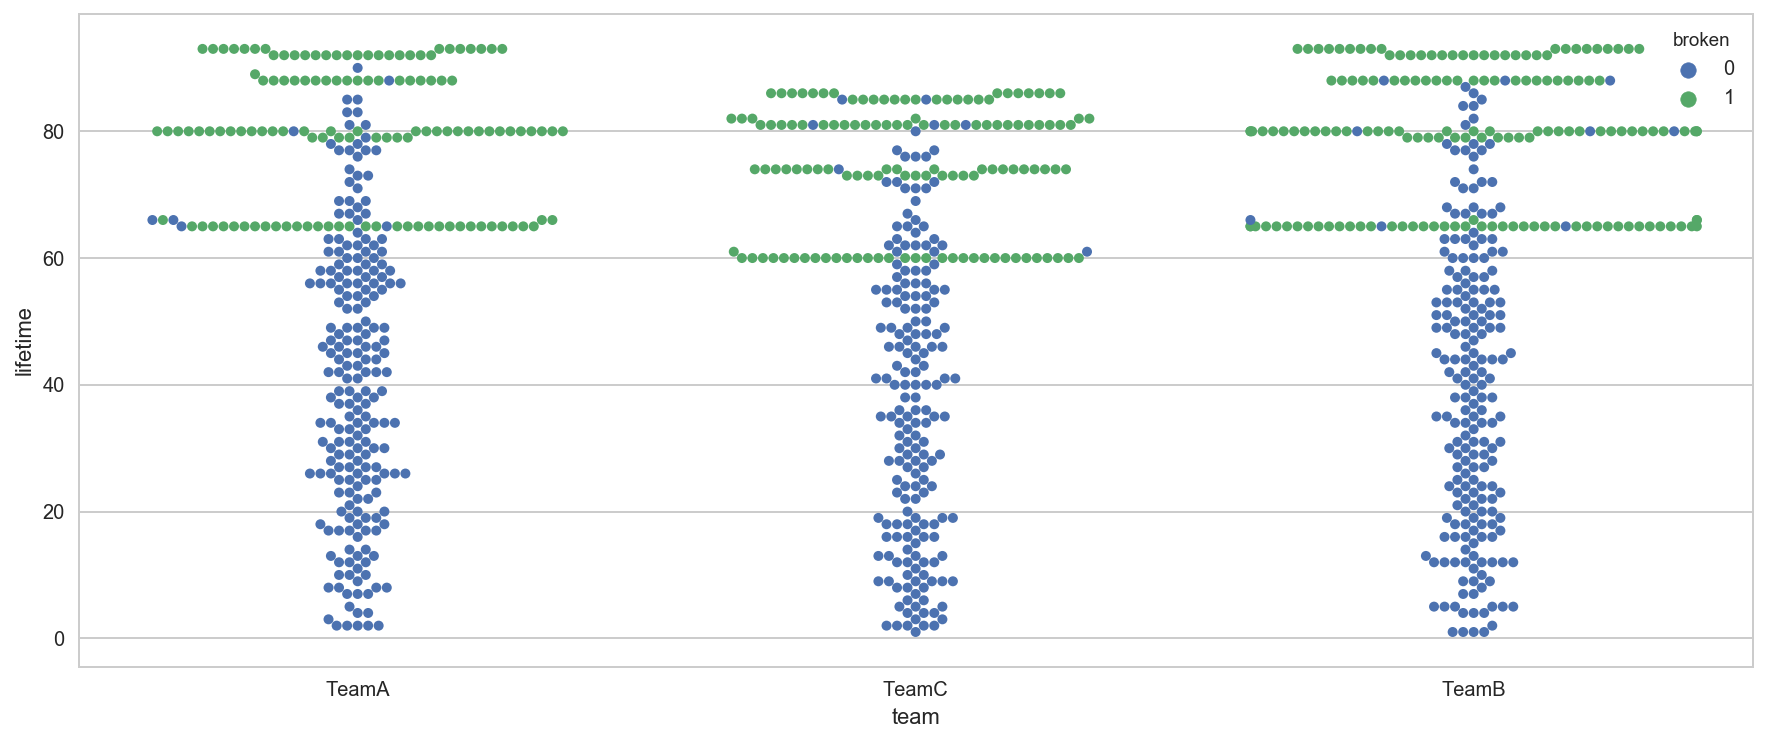

In [8]:
ax=sns.swarmplot(x="team", y="lifetime", hue="broken",data=df)

#### Plotting the Distribution plots for the input machine parameters

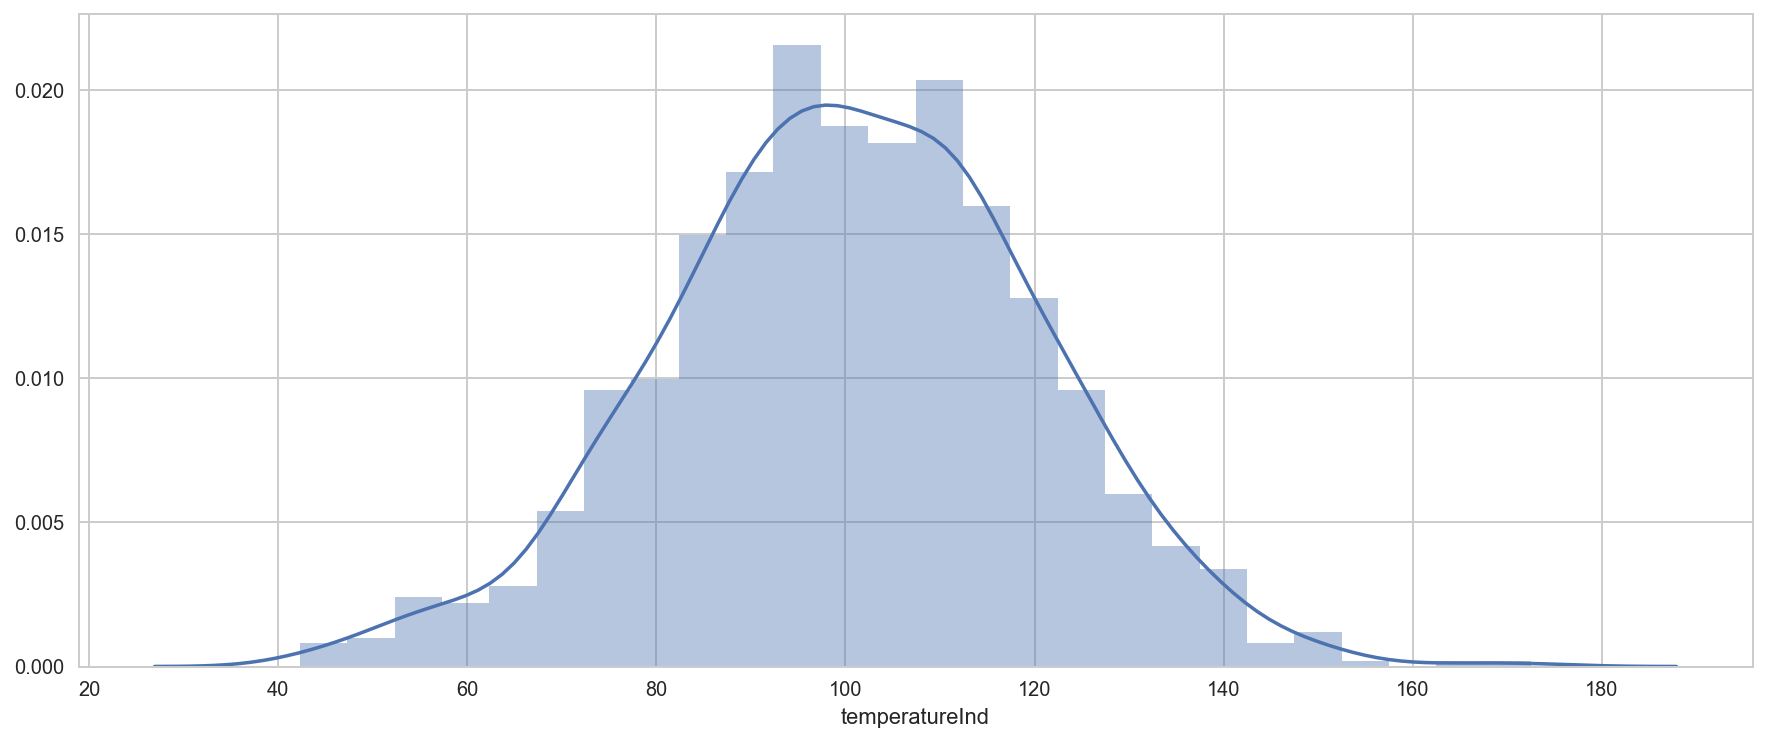

In [9]:
ax=sns.distplot(df['temperatureInd'])

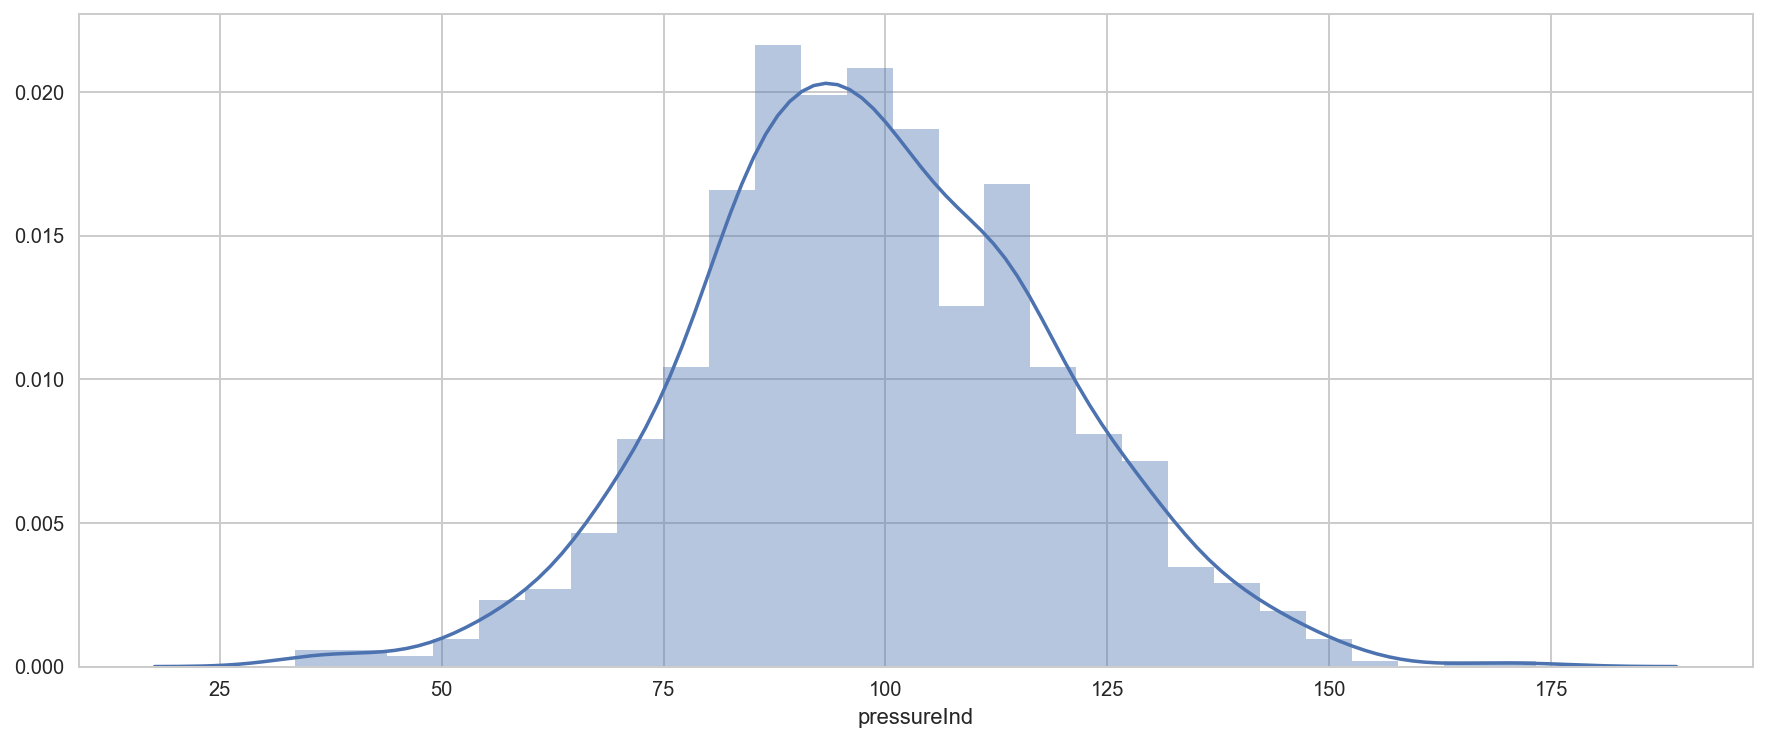

In [10]:
ax=sns.distplot(df['pressureInd'])

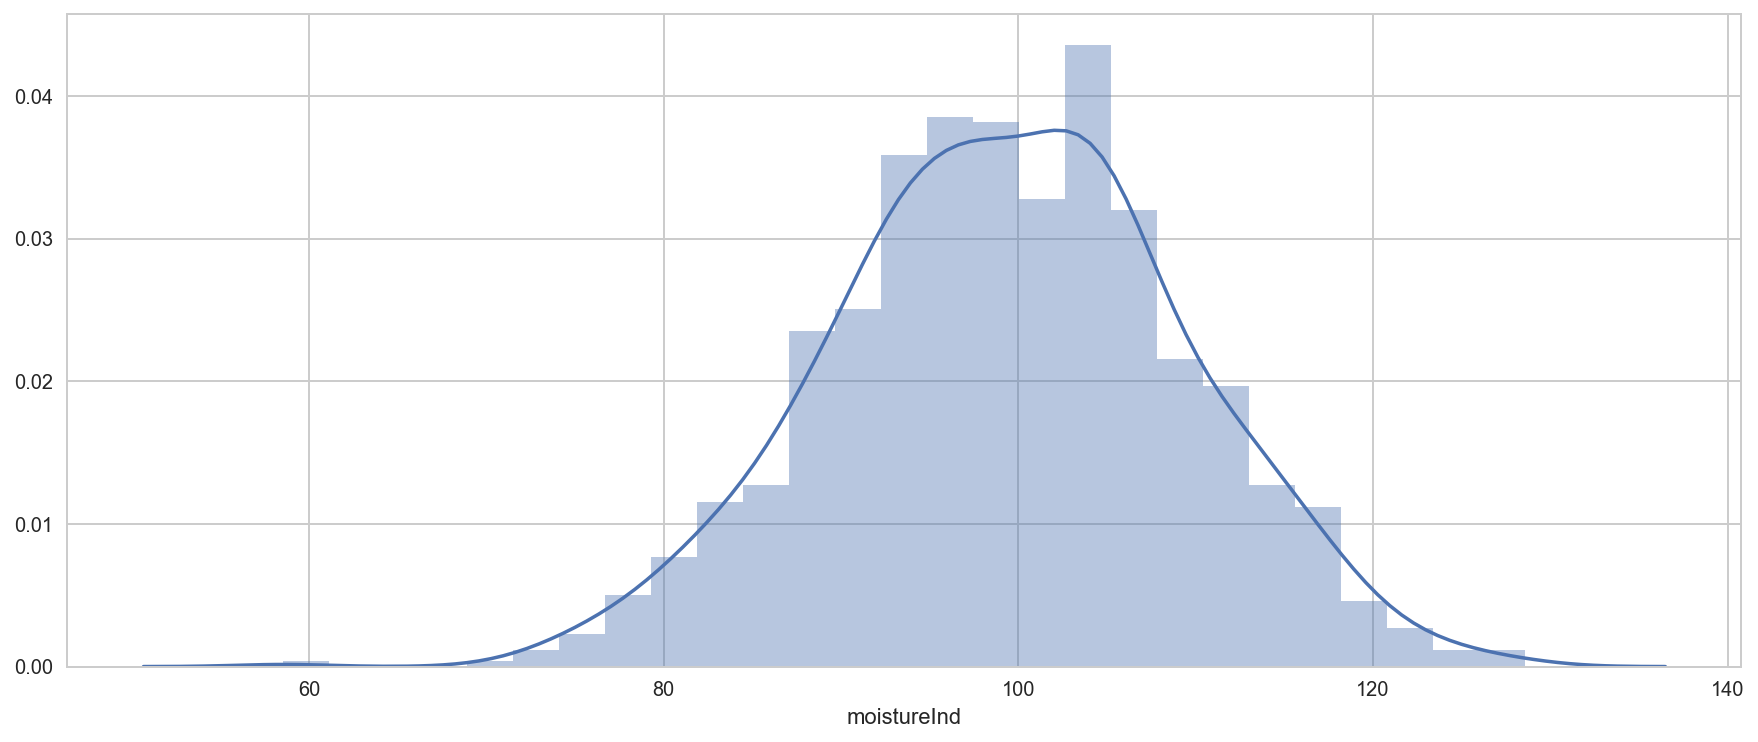

In [11]:
ax=sns.distplot(df['moistureInd'])

#### Plotting scatter matrices for pressure versus temperture for various providers

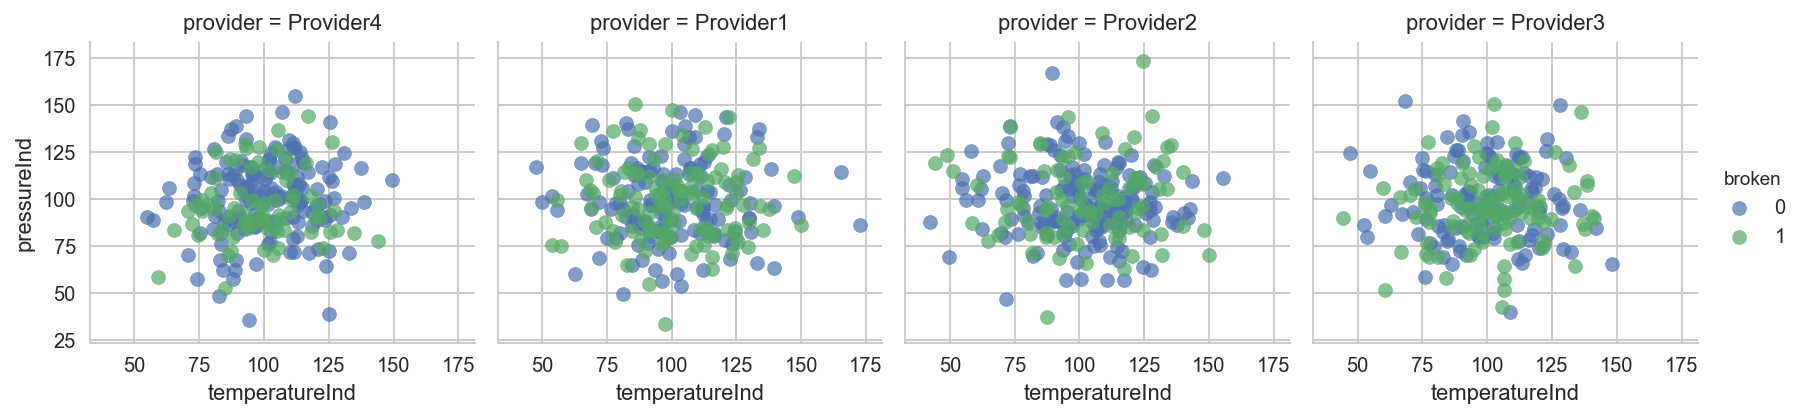

In [12]:
g = sns.FacetGrid(df, col="provider", hue="broken")
g.map(plt.scatter, "temperatureInd", "pressureInd", alpha=.7)
g.add_legend()

#### Plotting scatter matrices for pressure versus temperture for various teams

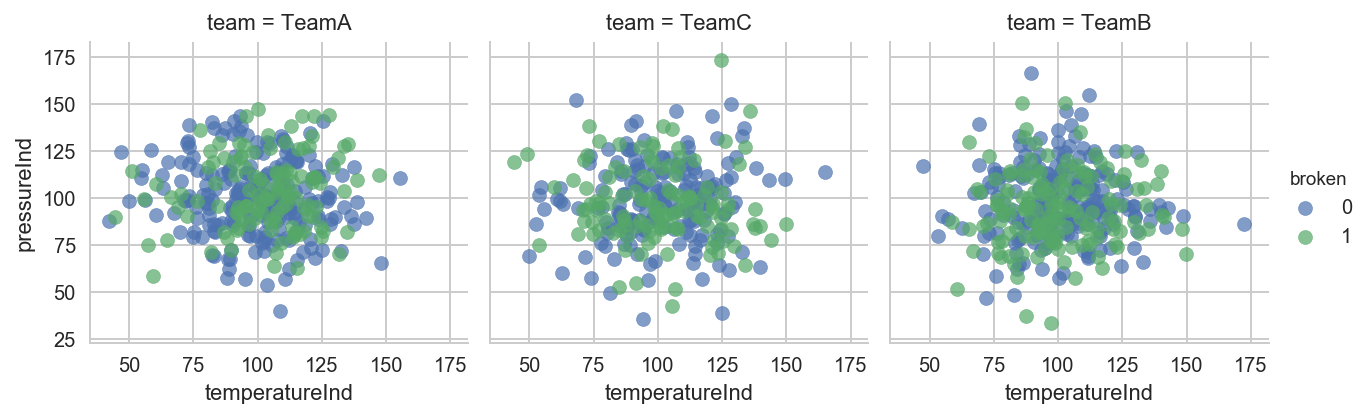

In [13]:
g = sns.FacetGrid(df, col="team", hue="broken")
g.map(plt.scatter, "temperatureInd", "pressureInd", alpha=.7)
g.add_legend()

#### Bivariate Hexbin plot

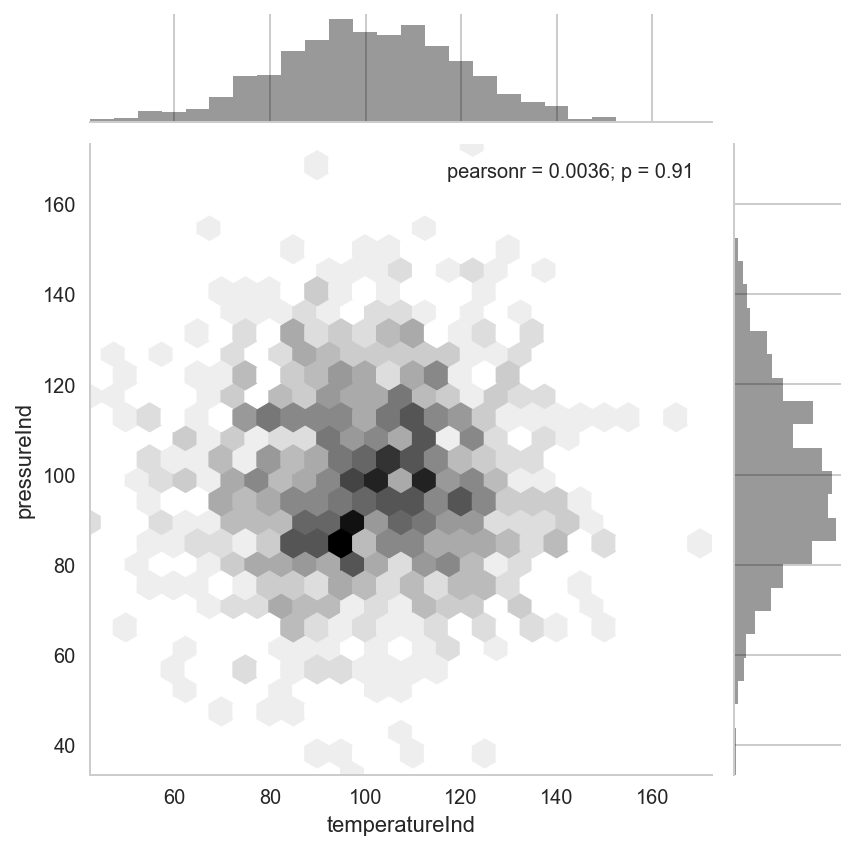

In [14]:
sns.jointplot(x= "temperatureInd", y= "pressureInd", kind="hex", color="k",data=df)

#### Continuous bivariate density plot for input parameters

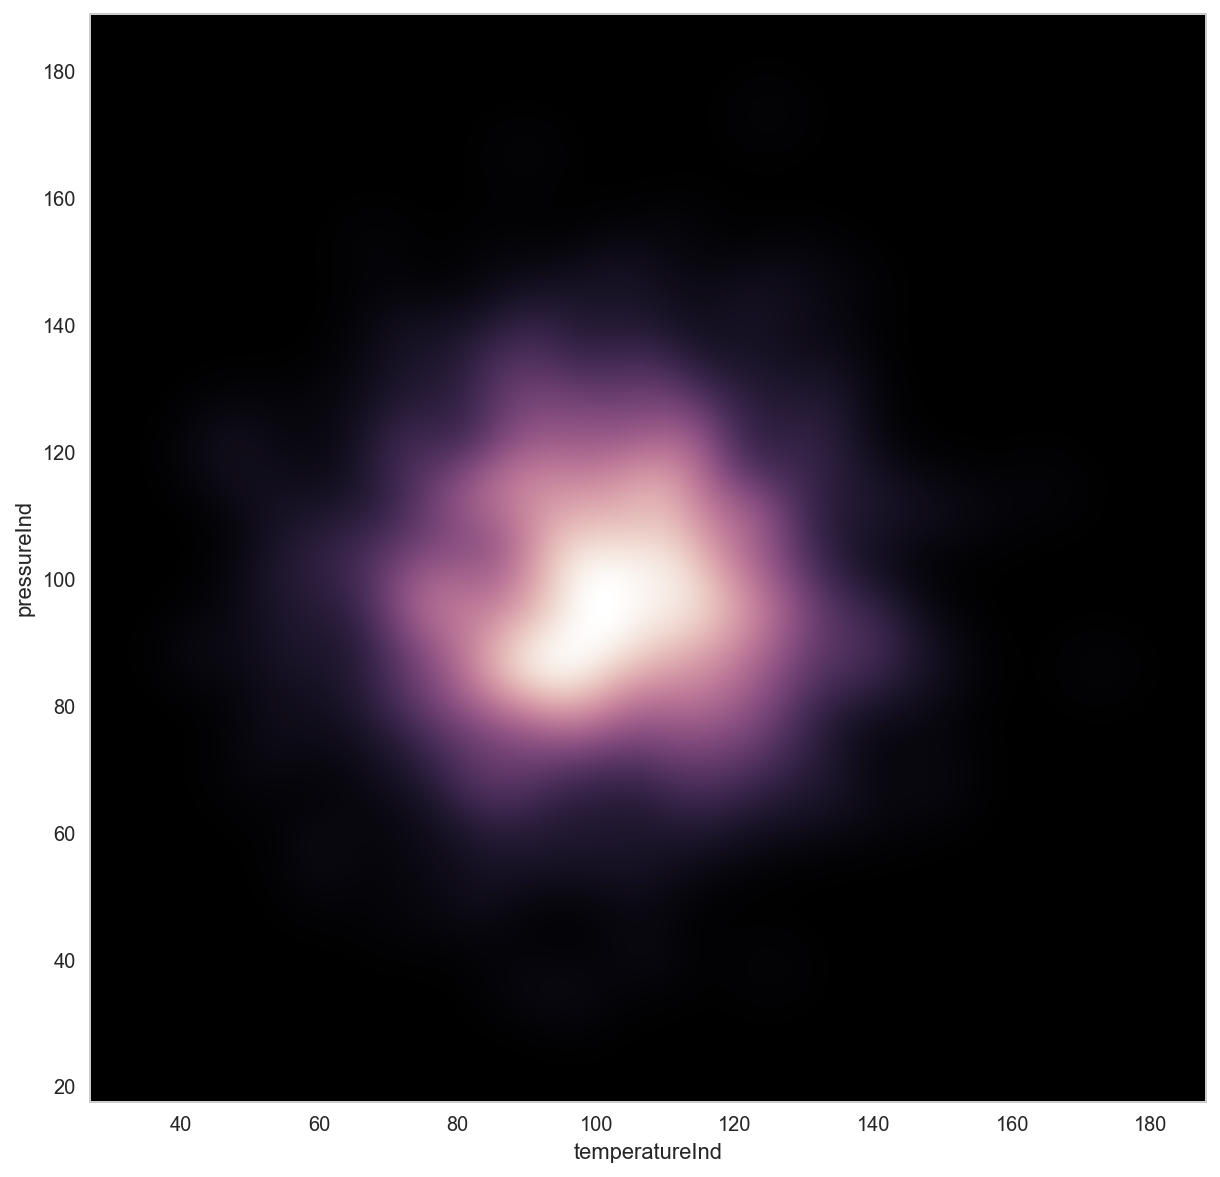

In [15]:
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(df.temperatureInd, df.pressureInd, cmap=cmap, n_levels=1000, shade=True)

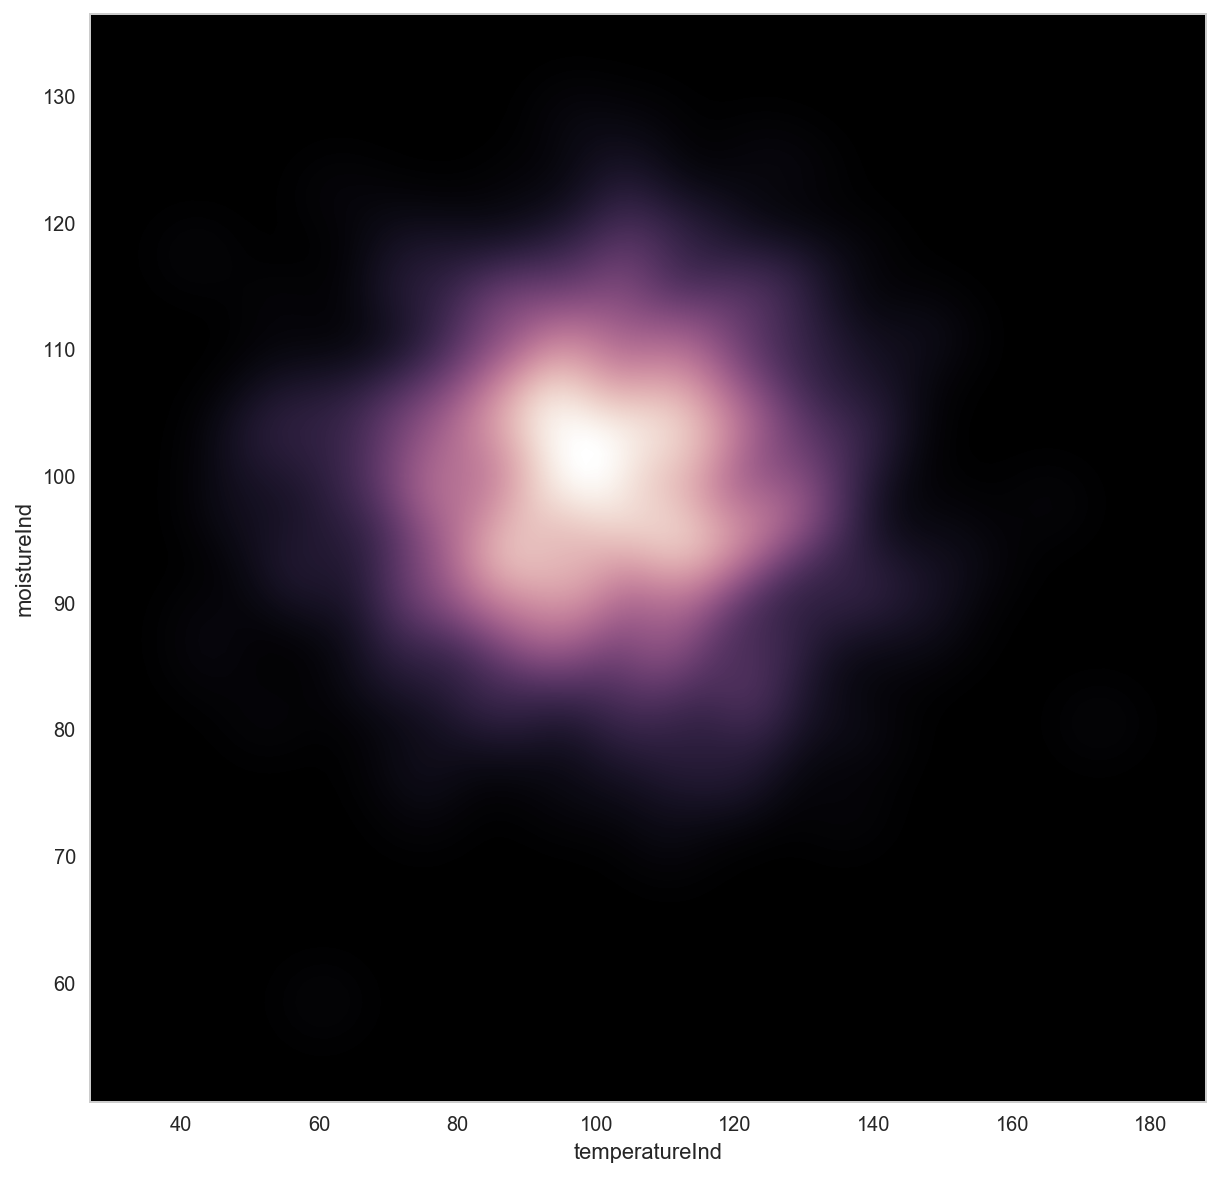

In [16]:
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(df.temperatureInd, df.moistureInd, cmap=cmap, n_levels=1000, shade=True)

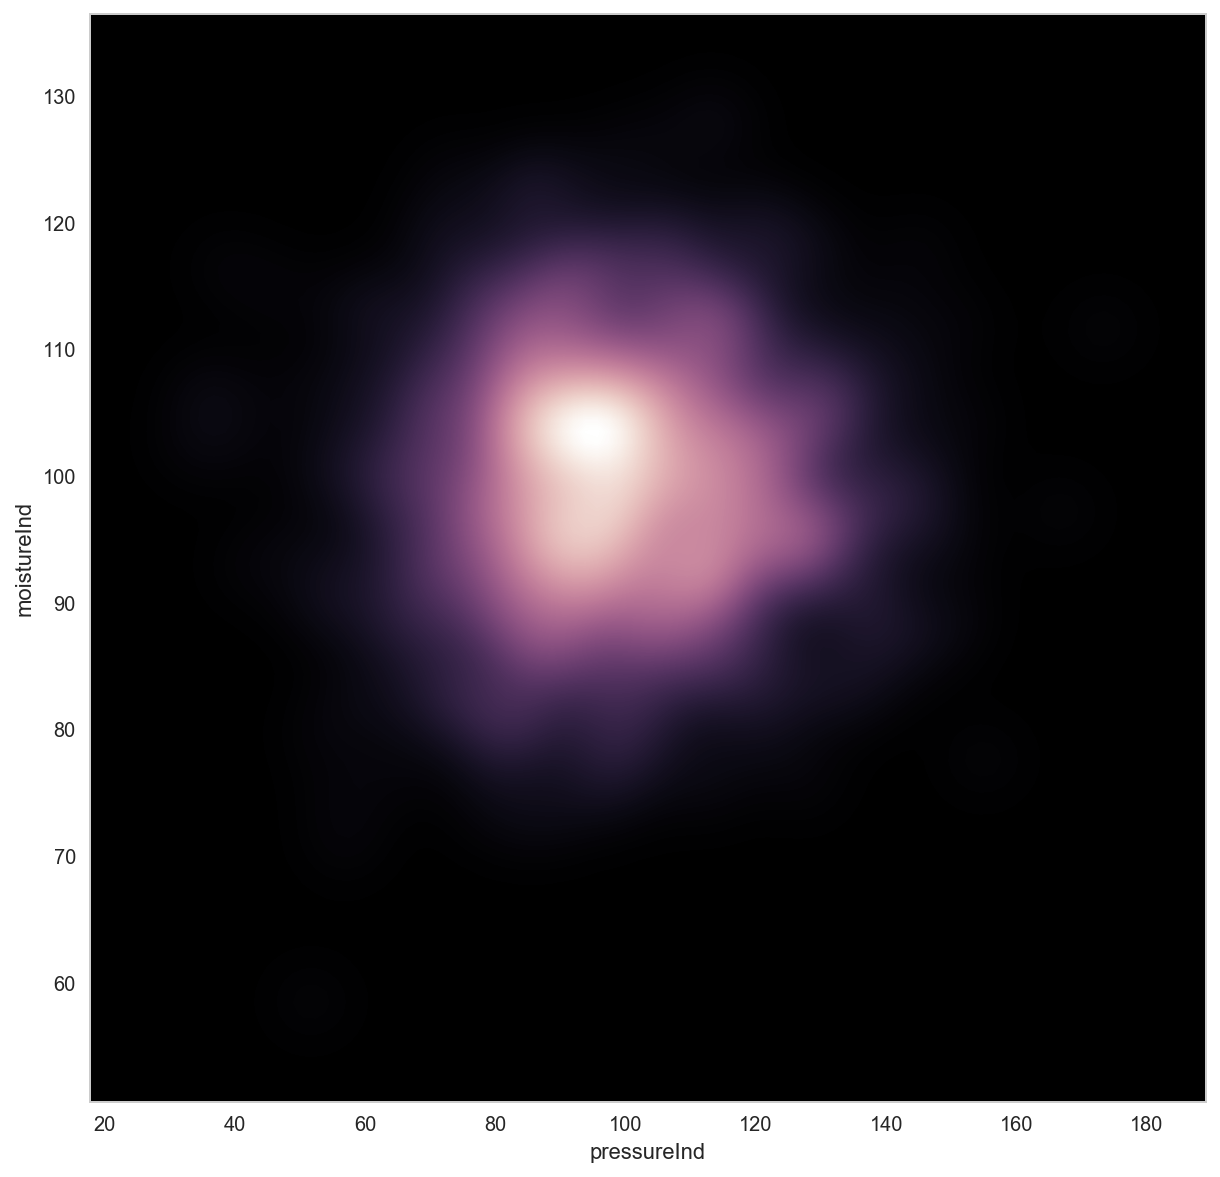

In [17]:
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.kdeplot(df.pressureInd, df.moistureInd, cmap=cmap, n_levels=1000, shade=True)

#### Visualizing regression plot

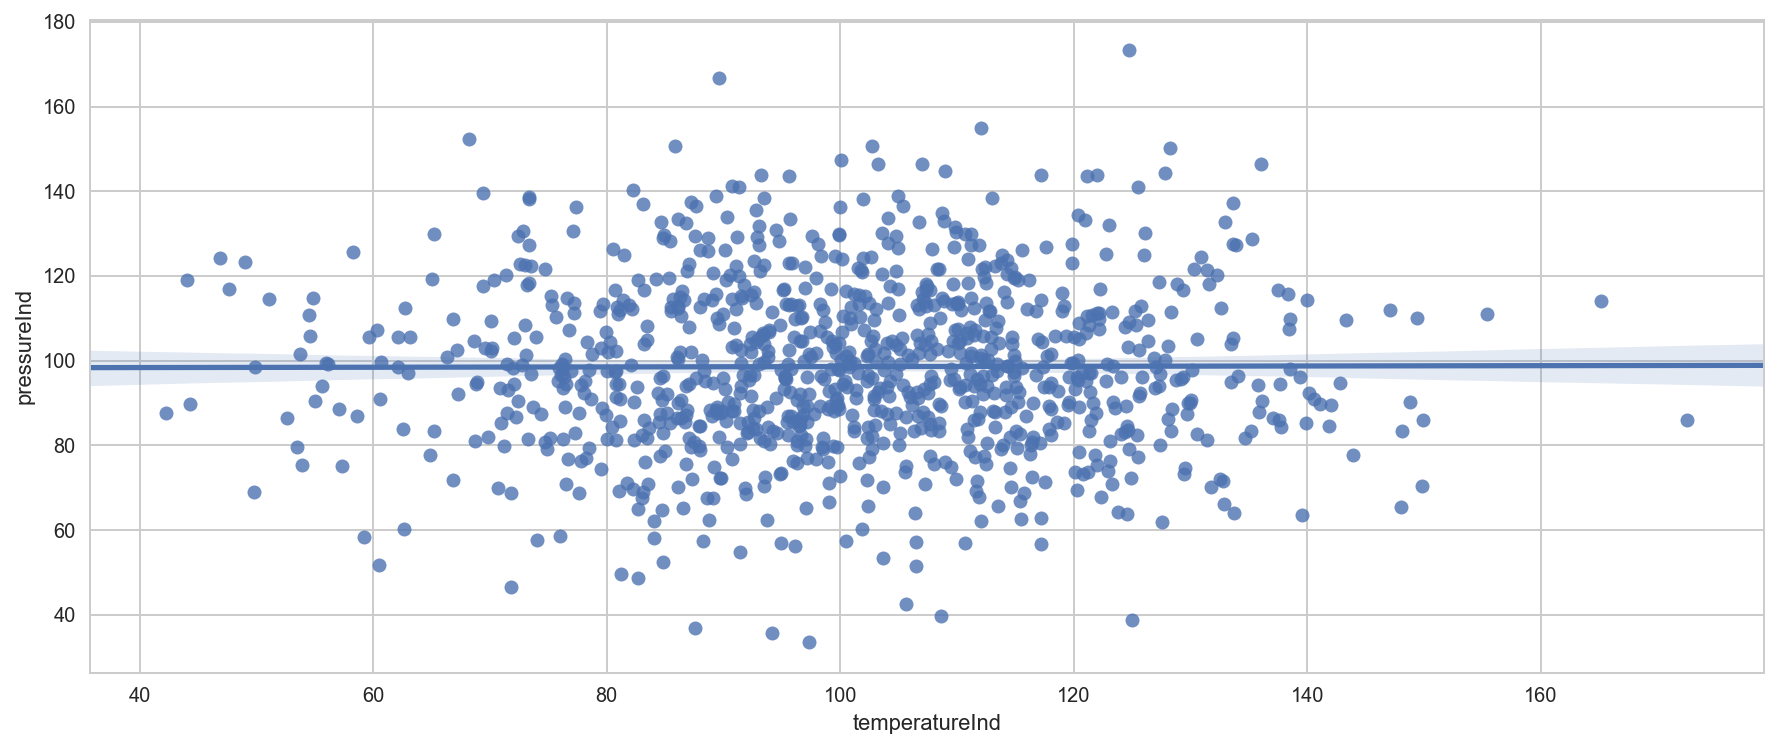

In [18]:
sns.regplot(x="temperatureInd", y="pressureInd", data=df)

#### Regression plots based on target variable

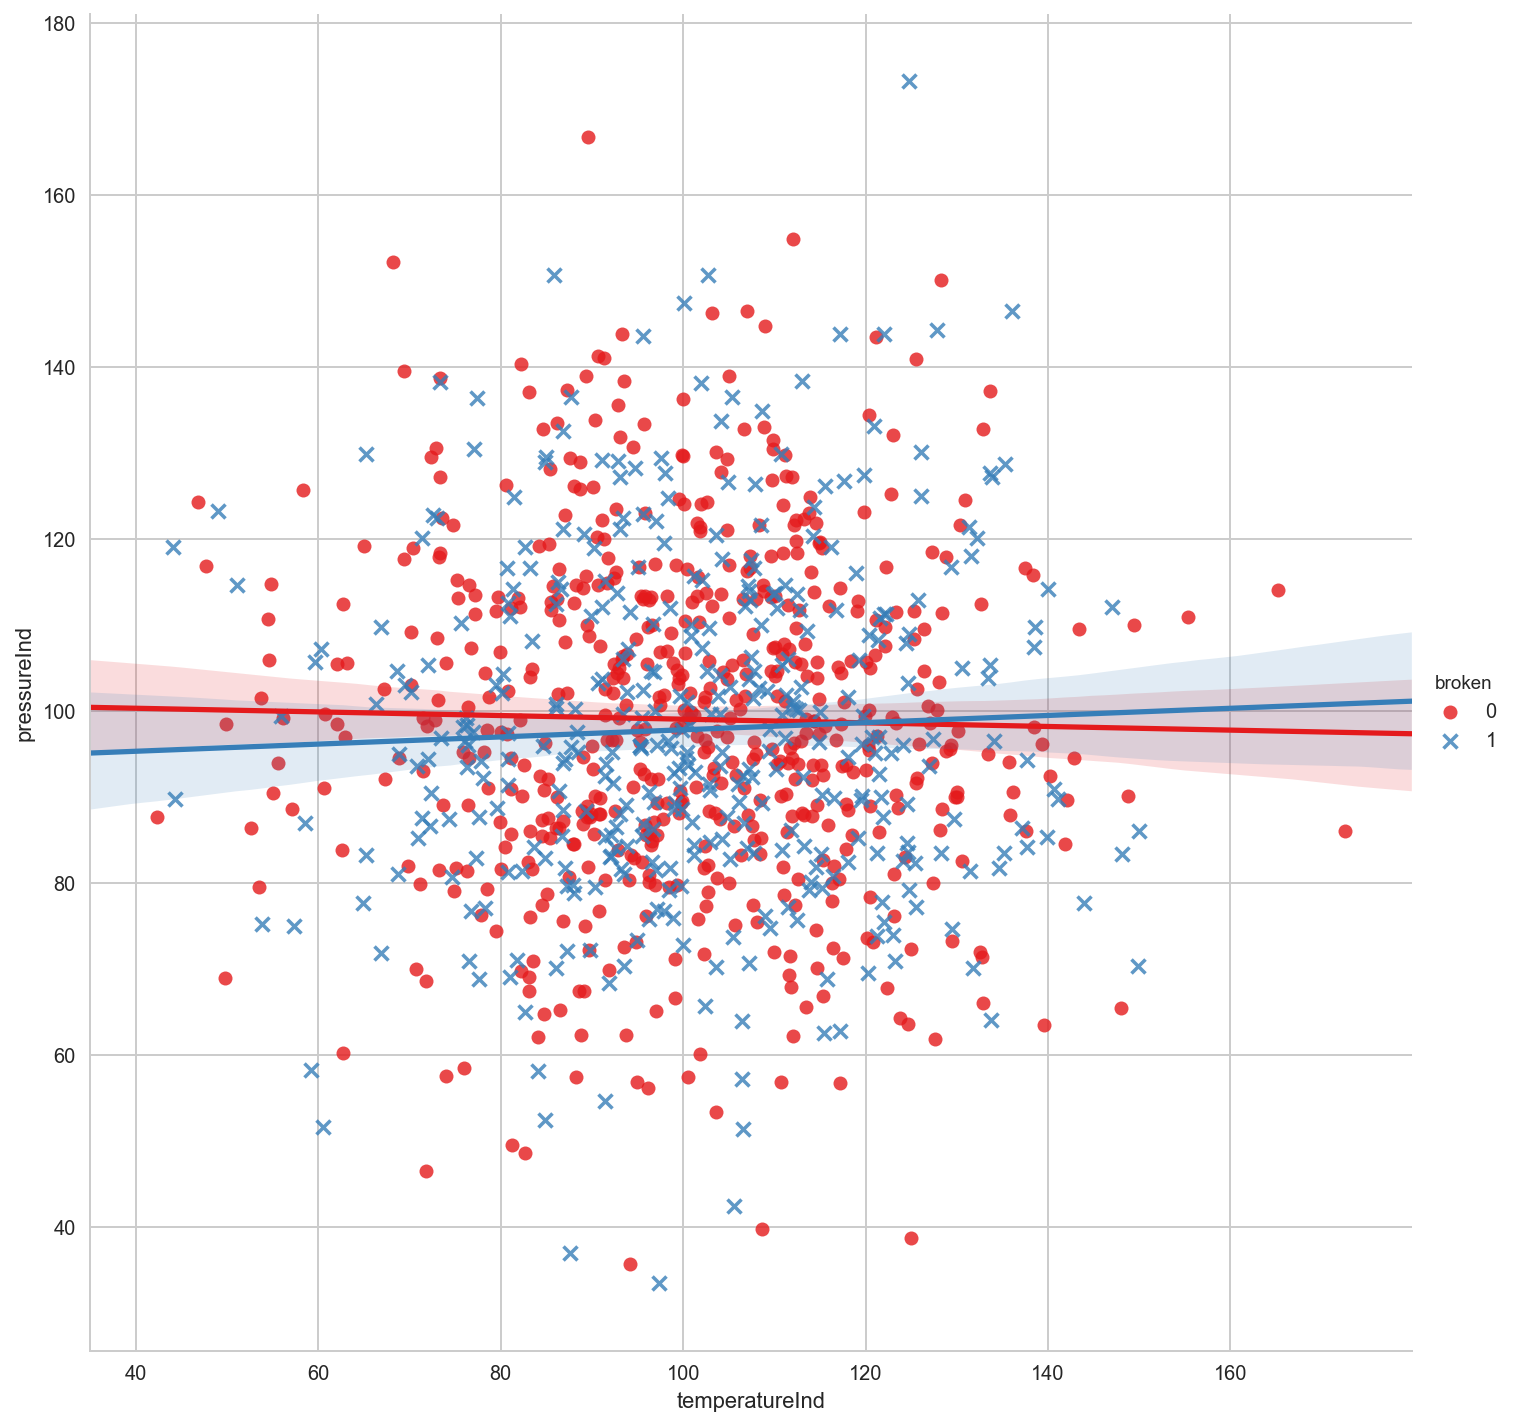

In [19]:

sns.lmplot(x="temperatureInd", y="pressureInd", hue="broken", data=df,markers=["o", "x"], palette="Set1",size=10)

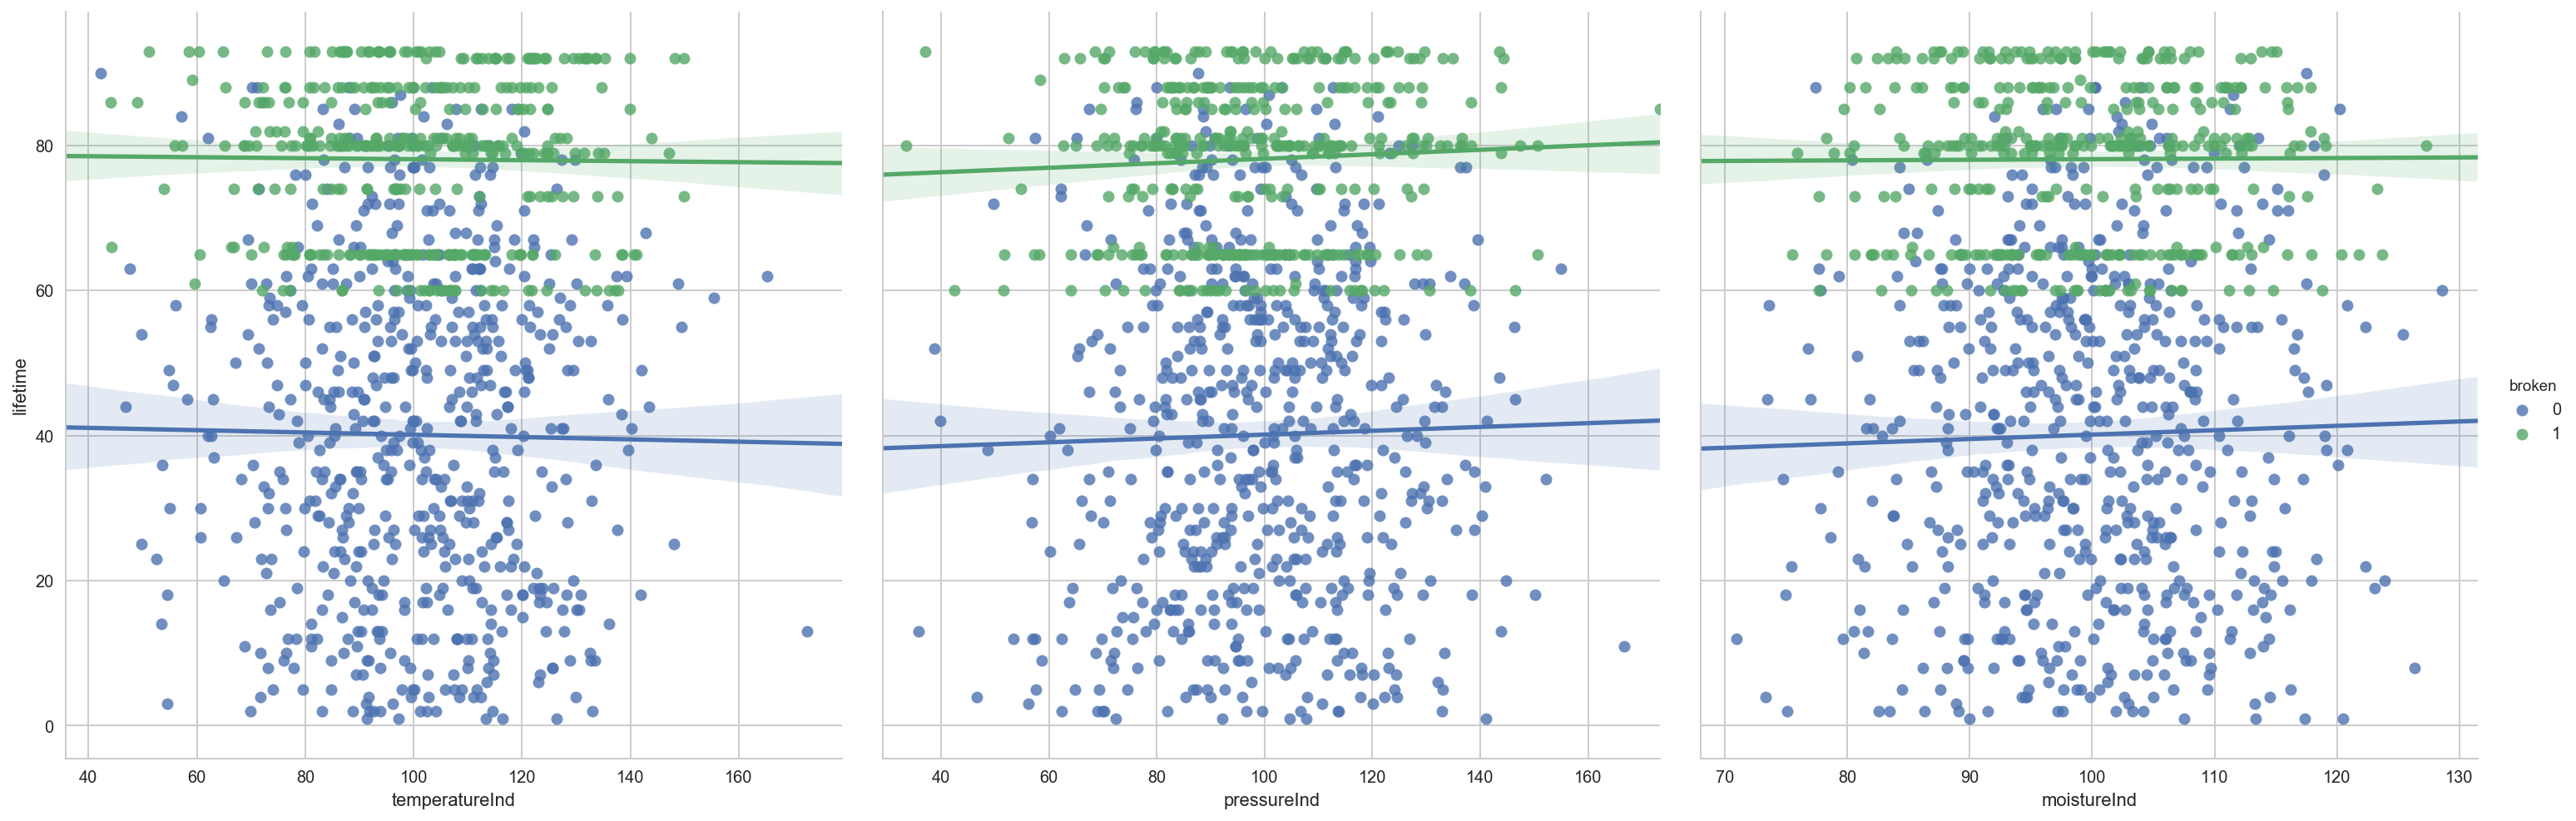

In [20]:
sns.pairplot(df, x_vars=["temperatureInd", "pressureInd","moistureInd"], y_vars=["lifetime"],
             hue="broken", size=7, aspect=1, kind="reg")

## Part 2 Applying various models

### Preparing the dataset

In [21]:
data=df[['moistureInd','temperatureInd','pressureInd','broken']]
data.shape
dataset=data.values
X = dataset[:,0:3].astype(float)
Y = dataset[:,3]
#Splitting the dataset into train and validation sets
validation_size = 0.30
seed = 21
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X, Y, test_size=validation_size, random_state=seed)


(1000, 4)

### Tinkering with different models

In [22]:
# Test options and evaluation metric
num_folds = 10
num_instances = len(X_train)
seed = 3

# Spot Check Algorithms
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART Decision Tree', DecisionTreeClassifier()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "model = %s:\n mean = %f std = (%f)\n" % (name, cv_results.mean(), cv_results.std())
    print(msg)


model = Logistic Regression:
 mean = 0.597143 std = (0.037688)

model = Linear Discriminant Analysis:
 mean = 0.597143 std = (0.037688)

model = KNN:
 mean = 0.534286 std = (0.037362)

model = CART Decision Tree:
 mean = 0.524286 std = (0.046092)

model = Naive Bayes:
 mean = 0.582857 std = (0.039795)

model = SVM:
 mean = 0.588571 std = (0.039279)



### Testing a Deep Neural Network

In [23]:
# create model
model = Sequential()
model.add(Dense(20, input_dim=3,activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(1, activation='softmax'))

optimizers=['adam']

accu={}
for myoptimizer in optimizers:
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=myoptimizer, metrics=['accuracy'])
    # Fit the model
    model.fit(X_train,Y_train, nb_epoch=1000,verbose=0, batch_size=10)
    # evaluate the model
    scores = model.evaluate(X_validation, Y_validation)
    accu[myoptimizer]=scores[1]*100
print "\n",accu

 32/300 [==>...........................] - ETA: 0s
{'adam': 38.666666626930237}


### Model from [this](https://www.kaggle.com/naweill/test1) link

('RF', 0.98733221241417957, 0.013131680102159708)
('LR', 0.97340255009107468, 0.012519596229618311)
('GNB', 0.94568665055345369, 0.017661060151020203)
('SVC', 0.96413906403250649, 0.017739542118266359)
('NN', 0.94270873616365414, 0.0217041786335995)
1000
0.966707186152


(-0.1, 1.1)

(-0.1, 1.1)

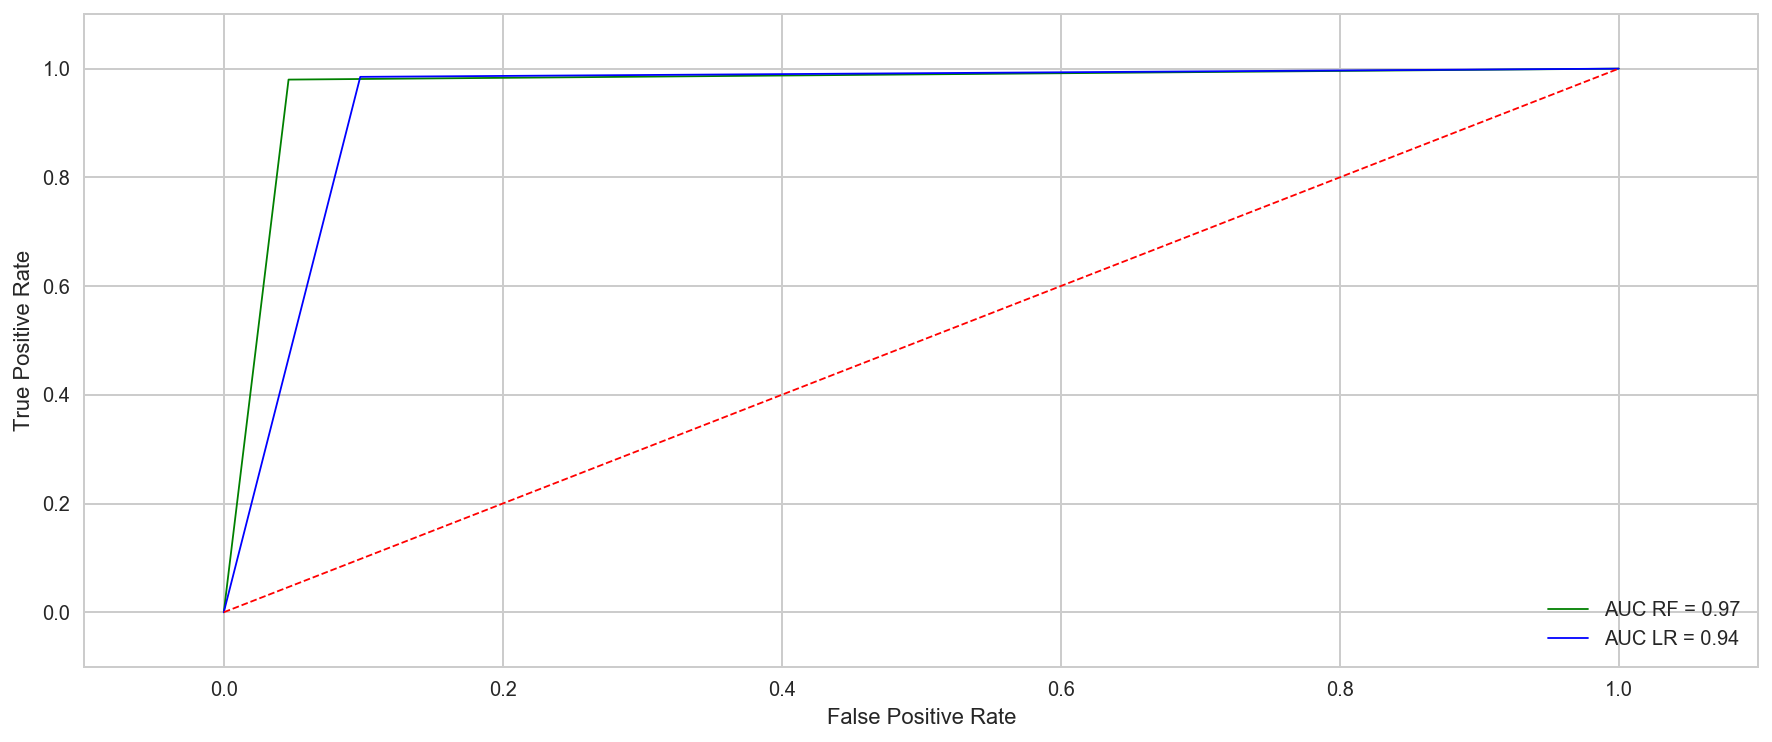

In [24]:
data = pd.read_csv("./maintenance_data.csv")
inputCat = data[["team","provider"]]
inputCatDummy = pd.get_dummies(inputCat)
inputCont = data[["pressureInd","moistureInd","temperatureInd","lifetime"]]
input = pd.concat([inputCont,inputCatDummy],axis=1)
output = data[["broken"]]
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']


rf = ensemble.RandomForestClassifier()
lr = linear_model.LogisticRegression()
gnb = GaussianNB()
svc = svm.SVC(C=100,gamma= 0.001000)
nn = neural_network.MLPClassifier()

cv = 10
scores = cross_val_score(rf, input.as_matrix(),output.broken , cv=cv,scoring = "roc_auc")
print ("RF",scores.mean(),scores.std())
scores = cross_val_score(lr, input.as_matrix(),output.broken , cv=cv,scoring = "roc_auc")
print ("LR",scores.mean(),scores.std())
scores = cross_val_score(gnb, input.as_matrix(),output.broken , cv=cv,scoring = "roc_auc")
print ("GNB",scores.mean(),scores.std())
scores = cross_val_score(svc, input.as_matrix(),output.broken , cv=cv,scoring = "roc_auc")
print ("SVC",scores.mean(),scores.std())
scores = cross_val_score(nn, input.as_matrix(),output.broken , cv=cv,scoring = "roc_auc")
print ("NN",scores.mean(),scores.std())

predictedRF = cross_val_predict(rf, input.as_matrix(), output.broken, cv=cv)
predictedLR = cross_val_predict(lr, input.as_matrix(), output.broken, cv=cv)
predictedGNB = cross_val_predict(gnb, input.as_matrix(), output.broken, cv=cv)
predictedSVC = cross_val_predict(svc, input.as_matrix(), output.broken, cv=cv)
predictedNN = cross_val_predict(nn, input.as_matrix(), output.broken, cv=cv)

print (len(predictedLR))
false_positive_rateRF, true_positive_rateRF, thresholdsRF = roc_curve(output.broken, predictedRF)
roc_aucRF = auc(false_positive_rateRF, true_positive_rateRF)
false_positive_rateLR, true_positive_rateLR, thresholdsLR = roc_curve(output.broken, predictedLR)
roc_aucLR = auc(false_positive_rateLR, true_positive_rateLR)

print (roc_aucRF)

plt.plot(false_positive_rateRF, true_positive_rateRF, 'g',label='AUC RF = %0.2f'% roc_aucRF,linewidth=0.9)
plt.plot(false_positive_rateLR, true_positive_rateLR, 'b',label='AUC LR = %0.2f'% roc_aucLR,linewidth=0.9)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--',linewidth=0.9)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')